## Use BentoML with ONNX model zoo(resnet50)

**BentoML makes moving trained ML models to production easy:**

* Package models trained with **any ML framework** and reproduce them for model serving in production
* **Deploy anywhere** for online API serving or offline batch serving
* High-Performance API model server with *adaptive micro-batching* support
* Central hub for managing models and deployment process via Web UI and APIs
* Modular and flexible design making it *adaptable to your infrastrcuture*

BentoML is a framework for serving, managing, and deploying machine learning models. It is aiming to bridge the gap between Data Science and DevOps, and enable teams to deliver prediction services in a fast, repeatable, and scalable way.

Before reading this example project, be sure to check out the [Getting started guide](https://github.com/bentoml/BentoML/blob/master/guides/quick-start/bentoml-quick-start-guide.ipynb) to learn about the basic concepts in BentoML.

This example notebook demonstrates how to use ONNX model zoo with BentoML.  It defines a BentoService with `resnet50` model and deploys it to AWS sagemaker as an API endpoint.

original notebook: https://github.com/onnx/onnx-docker/blob/master/onnx-ecosystem/inference_demos/resnet50_modelzoo_onnxruntime_inference.ipynb


![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=onnx&ea=onnx-resnet50&dt=onnx-resnet50)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
!pip install -q bentoml onnx>=1.7.0 onnxruntime>=1.4.0

In [5]:
import numpy as np    # we're going to use numpy to process input and output data
import onnxruntime    # to inference ONNX models, we use the ONNX Runtime
import onnx
from onnx import numpy_helper
import urllib.request
import json
import time

# display images in notebook
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

%matplotlib inline

In [3]:
onnx_model_url = "https://s3.amazonaws.com/onnx-model-zoo/resnet/resnet50v2/resnet50v2.tar.gz"
imagenet_labels_url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"

# retrieve our model from the ONNX model zoo
urllib.request.urlretrieve(onnx_model_url, filename="resnet50v2.tar.gz")
urllib.request.urlretrieve(imagenet_labels_url, filename="imagenet-simple-labels.json")

!curl https://raw.githubusercontent.com/onnx/onnx-docker/master/onnx-ecosystem/inference_demos/images/dog.jpg -o dog.jpg
!tar xvzf resnet50v2.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 21240  100 21240    0     0  59830      0 --:--:-- --:--:-- --:--:-- 59662
x resnet50v2/
x resnet50v2/resnet50v2.onnx
x resnet50v2/test_data_set_0/
x resnet50v2/test_data_set_1/
x resnet50v2/test_data_set_2/
x resnet50v2/test_data_set_2/input_0.pb
x resnet50v2/test_data_set_2/output_0.pb
x resnet50v2/test_data_set_1/input_0.pb
x resnet50v2/test_data_set_1/output_0.pb
x resnet50v2/test_data_set_0/input_0.pb
x resnet50v2/test_data_set_0/output_0.pb


### Load sample outputs and inputs

In [4]:
test_data_dir = 'resnet50v2/test_data_set'
test_data_num = 3

In [5]:
import glob
import os

# Load inputs
inputs = []
for i in range(test_data_num):
    input_file = os.path.join(test_data_dir + '_{}'.format(i), 'input_0.pb')
    tensor = onnx.TensorProto()
    with open(input_file, 'rb') as f:
        tensor.ParseFromString(f.read())
        inputs.append(numpy_helper.to_array(tensor))

print('Loaded {} inputs successfully.'.format(test_data_num))
        
# Load reference outputs

ref_outputs = []
for i in range(test_data_num):
    output_file = os.path.join(test_data_dir + '_{}'.format(i), 'output_0.pb')
    tensor = onnx.TensorProto()
    with open(output_file, 'rb') as f:
        tensor.ParseFromString(f.read())    
        ref_outputs.append(numpy_helper.to_array(tensor))
        
print('Loaded {} reference outputs successfully.'.format(test_data_num))

Loaded 3 inputs successfully.
Loaded 3 reference outputs successfully.


In [6]:
def load_labels(path):
    with open(path) as f:
        data = json.load(f)
    return np.asarray(data)

labels = load_labels('imagenet-simple-labels.json')
labels

array(['tench', 'goldfish', 'great white shark', 'tiger shark',
       'hammerhead shark', 'electric ray', 'stingray', 'cock', 'hen',
       'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco',
       'indigo bunting', 'American robin', 'bulbul', 'jay', 'magpie',
       'chickadee', 'American dipper', 'kite', 'bald eagle', 'vulture',
       'great grey owl', 'fire salamander', 'smooth newt', 'newt',
       'spotted salamander', 'axolotl', 'American bullfrog', 'tree frog',
       'tailed frog', 'loggerhead sea turtle', 'leatherback sea turtle',
       'mud turtle', 'terrapin', 'box turtle', 'banded gecko',
       'green iguana', 'Carolina anole',
       'desert grassland whiptail lizard', 'agama',
       'frilled-necked lizard', 'alligator lizard', 'Gila monster',
       'European green lizard', 'chameleon', 'Komodo dragon',
       'Nile crocodile', 'American alligator', 'triceratops',
       'worm snake', 'ring-necked snake', 'eastern hog-nosed snake',
       'smooth green snak

In [9]:
%%writefile onnx_resnet50.py
from typing import List

import numpy as np

import bentoml
from bentoml.frameworks.onnx import OnnxModelArtifact
from bentoml.service.artifacts.common import PickleArtifact
from bentoml.adapters import ImageInput


@bentoml.env(infer_pip_packages=True)
@bentoml.artifacts([OnnxModelArtifact('model'), PickleArtifact('labels')])
class OnnxResnet50(bentoml.BentoService):
    def preprocess(self, input_data):
        # convert the input data into the float32 input
        img_data = np.stack(input_data).transpose(0, 3, 1, 2)

        #normalize
        mean_vec = np.array([0.485, 0.456, 0.406])
        stddev_vec = np.array([0.229, 0.224, 0.225])


        norm_img_data = np.zeros(img_data.shape).astype('float32')


        for i in range(img_data.shape[0]):
            for j in range(img_data.shape[1]):
                norm_img_data[i,j,:,:] = (img_data[i,j,:,:]/255 - mean_vec[j]) / stddev_vec[j]

        #add batch channel
        norm_img_data = norm_img_data.reshape(-1, 3, 224, 224).astype('float32')
        return norm_img_data

    def softmax(self, x):
        x = x.reshape(-1)
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)
    
    def post_process(self, raw_result):
        return self.softmax(np.array(raw_result)).tolist()

    @bentoml.api(input=ImageInput(), batch=True)
    def predict(self, image_ndarrays: List[np.ndarray]) -> List[str]:
        input_datas = self.preprocess(image_ndarrays)
        input_name = self.artifacts.model.get_inputs()[0].name
        
        outputs = []
        for i in range(input_datas.shape[0]):
            raw_result = self.artifacts.model.run([], {input_name: input_datas[i:i+1]})
            result = self.post_process(raw_result)
            idx = np.argmax(result)
            sort_idx = np.flip(np.squeeze(np.argsort(result)))

            # return top 5 labels
            outputs.append(self.artifacts.labels[sort_idx[:5]])
        return outputs
        


Overwriting onnx_resnet50.py


In [10]:
from onnx_resnet50 import OnnxResnet50

svc = OnnxResnet50()
svc.pack('labels', labels)
svc.pack('model', 'resnet50v2/resnet50v2.onnx')

saved_path = svc.save()
saved_path

[2020-09-22 12:44:00,993] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-09-22 12:44:01,431] INFO - Using default docker base image: `None` specified inBentoML config file or env var. User must make sure that the docker base image either has Python 3.7 or conda installed.
[2020-09-22 12:44:03,187] INFO - Detected non-PyPI-released BentoML installed, copying local BentoML modulefiles to target saved bundle path..


/usr/local/anaconda3/envs/dev-py3/lib/python3.7/site-packages/setuptools/dist.py:476: UserWarning: Normalizing '0.9.0.pre+3.gcebf2015' to '0.9.0rc0+3.gcebf2015'
  normalized_version,
no previously-included directories found matching 'e2e_tests'
no previously-included directories found matching 'tests'
no previously-included directories found matching 'benchmark'


UPDATING BentoML-0.9.0rc0+3.gcebf2015/bentoml/_version.py
set BentoML-0.9.0rc0+3.gcebf2015/bentoml/_version.py to '0.9.0.pre+3.gcebf2015'
[2020-09-22 12:44:08,076] INFO - BentoService bundle 'OnnxResnet50:20200922124402_4DE94A' saved to: /Users/bozhaoyu/bentoml/repository/OnnxResnet50/20200922124402_4DE94A


'/Users/bozhaoyu/bentoml/repository/OnnxResnet50/20200922124402_4DE94A'

## REST API Model Serving


To start a REST API model server with the BentoService saved above, use the bentoml serve command:

In [ ]:
!bentoml serve OnnxResnet50:latest

[2020-09-22 14:29:26,500] INFO - Getting latest version OnnxResnet50:20200922124402_4DE94A
[2020-09-22 14:29:26,501] INFO - Starting BentoML API server in development mode..
[2020-09-22 14:29:26,680] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-09-22 14:29:26,696] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.9.0.pre, but loading from BentoML version 0.9.0.pre+3.gcebf2015
[2020-09-22 14:29:26,858] INFO - Using default docker base image: `None` specified inBentoML config file or env var. User must make sure that the docker base image either has Python 3.7 or conda installed.
 * Serving Flask app "OnnxResnet50" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http:/

If you are running this notebook from Google Colab, you can start the dev server with `--run-with-ngrok` option, to gain acccess to the API endpoint via a public endpoint managed by [ngrok](https://ngrok.com/):

In [ ]:
!bentoml serve OnnxResnet50:latest --run-with-ngrok

Sending POST request from termnial:
```bash
curl -X POST "http://127.0.0.1:5000/predict" -F image=@dog.jpg
```

```bash
curl -X POST "http://127.0.0.1:5000/predict" -H "Content-Type: image/png" --data-binary @dog.jpg
```

Go visit http://127.0.0.1:5000/ from your browser, click `/predict` -> `Try it out` -> `Choose File` -> `Execute` to sumbit an image from your computer

## Containerize model server with Docker


One common way of distributing this model API server for production deployment, is via Docker containers. And BentoML provides a convenient way to do that.

Note that docker is **not available in Google Colab**. You will need to download and run this notebook locally to try out this containerization with docker feature.

If you already have docker configured, simply run the follow command to product a docker container serving the IrisClassifier prediction service created above:

In [1]:
!bentoml containerize OnnxResnet50:latest

[2020-09-22 14:31:36,307] INFO - Getting latest version OnnxResnet50:20200922124402_4DE94A
Found Bento: /Users/bozhaoyu/bentoml/repository/OnnxResnet50/20200922124402_4DE94A
[2020-09-22 14:31:36,347] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-09-22 14:31:36,364] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.9.0.pre, but loading from BentoML version 0.9.0.pre+3.gcebf2015
Tag not specified, using tag parsed from BentoService: 'onnxresnet50:20200922124402_4DE94A'
Building Docker image onnxresnet50:20200922124402_4DE94A from OnnxResnet50:latest 
-we in here
processed docker file
(None, None)
root in create archive /Users/bozhaoyu/bentoml/repository/OnnxResnet50/20200922124402_4DE94A ['Dockerfile', 'MANIFEST.in', 'OnnxResnet50', 'On

In [2]:
!docker run --rm -p 5000:5000 onnxresnet50:20200922124402_4DE94A

[2020-09-22 21:35:25,206] INFO - Starting BentoML API server in production mode..
[2020-09-22 21:35:25,646] INFO - get_gunicorn_num_of_workers: 3, calculated by cpu count
[2020-09-22 21:35:25 +0000] [1] [INFO] Starting gunicorn 20.0.4
[2020-09-22 21:35:25 +0000] [1] [INFO] Listening at: http://0.0.0.0:5000 (1)
[2020-09-22 21:35:25 +0000] [1] [INFO] Using worker: sync
[2020-09-22 21:35:25 +0000] [12] [INFO] Booting worker with pid: 12
[2020-09-22 21:35:25 +0000] [13] [INFO] Booting worker with pid: 13
[2020-09-22 21:35:25 +0000] [14] [INFO] Booting worker with pid: 14
[2020-09-22 21:35:25,935] WARNING - Using BentoML not from official PyPI release. In order to find the same version of BentoML when deploying your BentoService, you must set the 'core/bentoml_deploy_version' config to a http/git location of your BentoML fork, e.g.: 'bentoml_deploy_version = git+https://github.com/{username}/bentoml.git@{branch}'
[2020-09-22 21:35:25,935] WARNING - Using BentoML not from official PyPI relea

## Launch inference job from CLI

BentoML cli supports loading and running a packaged model from CLI. With the DataframeInput adapter, the CLI command supports reading input Dataframe data from CLI argument or local csv or json files:

In [ ]:
!bentoml run OnnxResnet50:latest predict --input-file dog.jpg

## Load saved BentoService

bentoml.load is the API for loading a BentoML packaged model in python:

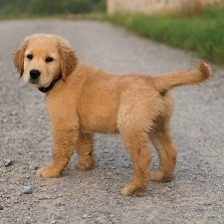

In [6]:
image = Image.open('dog.jpg')
image

In [11]:
from bentoml import load

loaded_svc = load(saved_path)


image_data = np.array(image)
np.array(loaded_svc.predict([image_data] * 4))

[2020-09-22 14:37:28,411] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-09-22 14:37:28,430] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.9.0.pre, but loading from BentoML version 0.9.0.pre+3.gcebf2015
[2020-09-22 14:37:28,838] INFO - Using default docker base image: `None` specified inBentoML config file or env var. User must make sure that the docker base image either has Python 3.7 or conda installed.
[2020-09-22 14:37:28,866] INFO - Initializing onnxruntime InferenceSession from onnx file:'/Users/bozhaoyu/bentoml/repository/OnnxResnet50/20200922124402_4DE94A/OnnxResnet50/artifacts/model.onnx'


array([['Golden Retriever', 'Labrador Retriever', 'Sussex Spaniel',
        'Vizsla', 'Otterhound'],
       ['Golden Retriever', 'Labrador Retriever', 'Sussex Spaniel',
        'Vizsla', 'Otterhound'],
       ['Golden Retriever', 'Labrador Retriever', 'Sussex Spaniel',
        'Vizsla', 'Otterhound'],
       ['Golden Retriever', 'Labrador Retriever', 'Sussex Spaniel',
        'Vizsla', 'Otterhound']], dtype='<U32')

# Deployment Options

If you are at a small team with limited engineering or DevOps resources, try out automated deployment with BentoML CLI, currently supporting AWS Lambda, AWS SageMaker, and Azure Functions:
- [AWS Lambda Deployment Guide](https://docs.bentoml.org/en/latest/deployment/aws_lambda.html)
- [AWS SageMaker Deployment Guide](https://docs.bentoml.org/en/latest/deployment/aws_sagemaker.html)
- [Azure Functions Deployment Guide](https://docs.bentoml.org/en/latest/deployment/azure_functions.html)

If the cloud platform you are working with is not on the list above, try out these step-by-step guide on manually deploying BentoML packaged model to cloud platforms:
- [AWS ECS Deployment](https://docs.bentoml.org/en/latest/deployment/aws_ecs.html)
- [Google Cloud Run Deployment](https://docs.bentoml.org/en/latest/deployment/google_cloud_run.html)
- [Azure container instance Deployment](https://docs.bentoml.org/en/latest/deployment/azure_container_instance.html)
- [Heroku Deployment](https://docs.bentoml.org/en/latest/deployment/heroku.html)

Lastly, if you have a DevOps or ML Engineering team who's operating a Kubernetes or OpenShift cluster, use the following guides as references for implementating your deployment strategy:
- [Kubernetes Deployment](https://docs.bentoml.org/en/latest/deployment/kubernetes.html)
- [Knative Deployment](https://docs.bentoml.org/en/latest/deployment/knative.html)
- [Kubeflow Deployment](https://docs.bentoml.org/en/latest/deployment/kubeflow.html)
- [KFServing Deployment](https://docs.bentoml.org/en/latest/deployment/kfserving.html)
- [Clipper.ai Deployment Guide](https://docs.bentoml.org/en/latest/deployment/clipper.html)